In [75]:
import os
from os import listdir
from os.path import isfile, join
import glob
import string
import operator
import csv
import pandas as pd
import calendar
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon

In [3]:
homedir = os.path.expanduser("~")
path_to_data = homedir+"\\Final\\Data"
print(path_to_data)

C:\Users\priya\Final\Data


In [62]:
for subdir,dirs, files in os.walk(path_to_data):
    #print(files)
    for file in files:
        if file == 'database.csv':
            #print(file)
            csv_data1=pd.read_csv(os.path.join(subdir,file))
        if file == 'Population By State.csv':
            csv_data2=pd.read_csv(os.path.join(subdir,file))
csv_data1.head(5)

C:\Users\priya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [41]:
crime2010_df =  csv_data1[(csv_data1['Year'] == 2010)]
crime2011_df =  csv_data1[(csv_data1['Year'] == 2011)]
crime2012_df =  csv_data1[(csv_data1['Year'] == 2012)]
crime2013_df =  csv_data1[(csv_data1['Year'] == 2013)]
crime2014_df =  csv_data1[(csv_data1['Year'] == 2014)]

In [63]:
Main_df = csv_data1[(csv_data1.State != "Unknown")].groupby(['State']).size().order(ascending=False).to_frame(name = 'number of incidents').reset_index()
Main_df.head(20)

C:\Users\priya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


,State,number of incidents
0,California,99783
1,Texas,62095
2,New York,49268
3,Florida,37164
4,Michigan,28448
5,Illinois,25871
6,Pennsylvania,24236
7,Georgia,21088
8,North Carolina,20390
9,Louisiana,19629


In [26]:
csv_data2.shape


(53, 2)

In [128]:
final_df = pd.merge(Main_df,csv_data2,on='State',how='inner')
final_df.reset_index()
final_df.head(5)

,State,number of incidents,Population
0,California,99783,39250017.0
1,Texas,62095,27862596.0
2,New York,49268,19745289.0
3,Florida,37164,20612439.0
4,Michigan,28448,9928300.0


In [155]:
#final_df = final_df.convert_objects(convert_numeric=True)
final_df["murder crimes per 10,000"] = (final_df["number of incidents"])/(final_df["Population"])*10000
final_df.head(5)

,State,number of incidents,Population,"murder crimes per 10,000"
0,California,99783,39250017.0,25.422409
1,Texas,62095,27862596.0,22.286150
2,New York,49268,19745289.0,24.951775
3,Florida,37164,20612439.0,18.029890
4,Michigan,28448,9928300.0,28.653445


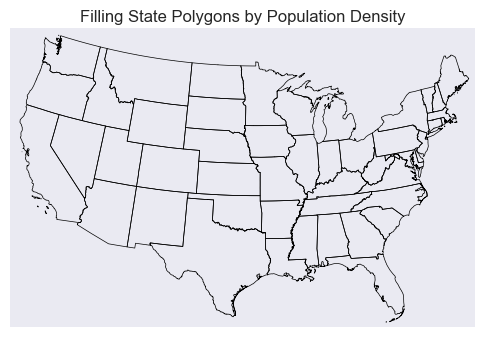

In [112]:
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('st99_d00',name='states',drawbounds=True)
# population density by state from
# http://en.wikipedia.org/wiki/List_of_U.S._states_by_population_density

# choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.hot # use 'hot' colormap
vmin = 0; vmax = 450 # set range.
for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['Puerto Rico']:
        pop = final_df[(final_df.State == statename)]['murder crimes per 10,000'] 
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
        #print(colors)
    statenames.append(statename)
# cycle through state names, color each one.
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    #print(nshape)
    if statenames[nshape] not in ['Puerto Rico']:
        a= statenames[nshape]
        #print(a)
        #print(colors[a])
        #if statenames[nshape] == 'Alaska':
        # Alaska is too big. Scale it down to 35% first, then transate it. 
            #seg = list(map(lambda(x,y): (0.35*x + 1100000, 0.35*y-1300000), seg))
        #if statenames[nshape] == 'Hawaii':
            #seg = list(map(lambda(x,y): (x + 5100000, y-900000), seg))
        #color = rgb2hex(colors[a]) 
        #poly = Polygon(seg,facecolor=color,edgecolor=color)
        #ax.add_patch(poly)
plt.title('Filling State Polygons by Population Density')
plt.show()

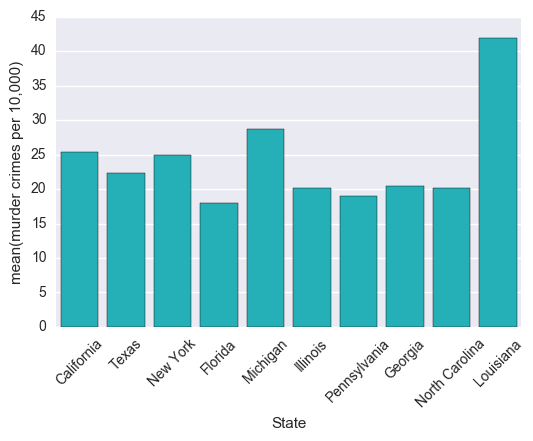

In [153]:
ax = sns.barplot(x="State", y="murder crimes per 10,000", data=final_df.head(10),color="#0DC5CF")
ax.set_xticklabels(final_df["State"], rotation=45)

# Conclusion

-The FBI's crime report for 2012 found nearly 68% of all homicides in America involved a firearm, and Louisiana fiercely protects the right to bear arms. The state passed an amendment in November making gun ownership a "fundamental right" like free speech and making it extremely difficult to pass laws that step on that right.
Louisiana also passed a law recently that lets its citizens apply for concealed carry handgun permits that last their entire lifetimes. Louisianans who want to walk around and openly carry their guns don't need a permit at all under the state's open carry law.